In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import keras
from keras.datasets import mnist
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.layers.recurrent import *
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

import numpy as np
RUN = 1
DATA_DIR = './speech_commands_v0.01'

Using TensorFlow backend.


In [0]:
def augtime(xdatat,fealen):
  X_data=[]
  for i in range(0,len(xdatat)):
    if len(xdatat[i])<fealen:
      tem=np.append(xdatat[i],xdatat[i][0:(fealen-len(xdatat[i]))])
      while len(tem)<fealen:
        tem=np.append(tem,xdatat[i][0:(fealen-len(tem))])
    else:
      tem=xdatat[i]
    X_data=np.append(X_data,tem,axis=0)
  X_test=np.reshape(X_data,(len(xdatat),fealen,1))
  return X_test

In [0]:
def autocnn_model(size, num_cnn_layers,classlen):
    NUM_FILTERS = 32
    MAX_NEURONS = 150
    model = Sequential()
    
    for i in range(1, num_cnn_layers+1):
        if i == 1:
            model.add(Conv1D(NUM_FILTERS*i, KERNEL=3, strides=2, input_shape=size, activation='relu', padding='same'))
        else:
            model.add(Conv1D(NUM_FILTERS*i, KERNEL=3, strides=2, activation='relu', padding='same'))
            model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(int(MAX_NEURONS), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(int(MAX_NEURONS/2), activation='relu'))
    model.add(Dense(classlen, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [0]:
def cnn_model(size, num_cnn_layers,classlen):
  m = Sequential()
  m.add(Conv1D(filters=16, kernel_size=3, strides=2, padding='valid', activation='relu', input_shape=size))
  m.add(MaxPooling1D(pool_size=2))
  m.add(BatchNormalization()) 
  m.add(Conv1D(filters=16, kernel_size=3, strides=2, padding='valid', activation='relu'))
  m.add(MaxPooling1D(pool_size=2))
  m.add(BatchNormalization())
  m.add(Conv1D(filters=16, kernel_size=3, strides=2, padding='valid', activation='relu'))
  m.add(MaxPooling1D(pool_size=2))
  m.add(BatchNormalization())
  m.add(Conv1D(filters=16, kernel_size=3, strides=2, padding='valid', activation='relu')) 
  m.add(MaxPooling1D(pool_size=2))
  m.add(BatchNormalization())
  m.add(Conv1D(filters=16, kernel_size=3, strides=3, padding='valid', activation='relu'))
  m.add(MaxPooling1D(pool_size=2))
  m.add(BatchNormalization())
  m.add(Conv1D(filters=32, kernel_size=3, strides=3, padding='valid', activation='relu'))
  m.add(MaxPooling1D(pool_size=2))
  m.add(BatchNormalization())
  m.add(Conv1D(filters=16, kernel_size=3, strides=2, padding='valid', activation='relu'))
  m.add(BatchNormalization())
  m.add(MaxPooling1D(pool_size=2))
  m.add(Dropout(0.15))
  m.add(Flatten())
  m.add(Dense(128, activation='relu'))
  m.add(Dropout(0.3))
  m.add(Dense(classlen, activation='softmax'))
  m.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])  
  return m


In [0]:
#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=0, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, fealen, conlen, classlen, EPOCHS=20, BATCH_SIZE=128, ):
    model = None
    model = cnn_model((fealen,1), conlen, classlen)
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_data=(val_x, val_y))
    print("Val_loss,Val_acc: ", model.evaluate(val_x, val_y))
    return results

In [0]:
def modelresults(model,xt, yt):
  y_pred_keras = model.predict(xt)
  yp=np.round(y_pred_keras, 2)
  yt=np.argmax(yt, 1)
  yp=np.argmax(yp, 1)
  print(classification_report(yt, yp))

  #function to draw confusion matrix
  conf_matx = confusion_matrix(yt, yp)
  sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
  plt.show()
 
  fpr_keras0, tpr_keras0, thresholds_keras0=roc_curve(y_test[:,0],y_pred_keras[:,0])
  auc_keras0 = auc(fpr_keras0, tpr_keras0)

  fpr_keras1, tpr_keras1, thresholds_keras1=roc_curve(y_test[:,1],y_pred_keras[:,1])
  auc_keras1 = auc(fpr_keras1, tpr_keras1)

  fpr_keras2, tpr_keras2, thresholds_keras2=roc_curve(y_test[:,2],y_pred_keras[:,2])
  auc_keras2 = auc(fpr_keras2, tpr_keras2)

  fpr_keras3, tpr_keras3, thresholds_keras3=roc_curve(y_test[:,3],y_pred_keras[:,3])
  auc_keras3 = auc(fpr_keras3, tpr_keras3)


  plt.plot([0,1],[0,1],'k--')
  plt.plot(fpr_keras0, tpr_keras0, label='C(area={:.3f})'.format(auc_keras0))
  plt.plot(fpr_keras1, tpr_keras1, label='N(area={:.3f})'.format(auc_keras1))
  plt.plot(fpr_keras2, tpr_keras2, label='R(area={:.3f})'.format(auc_keras2))
  plt.plot(fpr_keras3, tpr_keras3, label='W(area={:.3f})'.format(auc_keras3))
  #plt.plot(fpr_keras, tpr_keras) 
  #plt.plot(history.history['val_loss'])
  plt.title('ROC Curve')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  #plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.show()

  #return conf_matx

In [0]:
X1 = np.load("/content/drive/My Drive/Colab Notebooks/lungs/cnnCdata.npy",allow_pickle=True)
#X2 = np.load("/content/drive/My Drive/Colab Notebooks/lungs/cnnCWdata.npy",allow_pickle=True)
X3 = np.load("/content/drive/My Drive/Colab Notebooks/lungs/cnnNdata.npy",allow_pickle=True)
X4 = np.load("/content/drive/My Drive/Colab Notebooks/lungs/cnnRdata.npy",allow_pickle=True)
#X5 = np.load("/content/drive/My Drive/Colab Notebooks/lungs/cnnRWdata.npy",allow_pickle=True)
X6 = np.load("/content/drive/My Drive/Colab Notebooks/lungs/cnnWdata.npy",allow_pickle=True)

''''aX1 = np.load("/content/drive/My Drive/Colab Notebooks/lungs/augmentedcnnASdata.npy",allow_pickle=True)
aX2 = np.load("/content/drive/My Drive/Colab Notebooks/lungs/augmentedcnnMRdata.npy",allow_pickle=True)
aX3 = np.load("/content/drive/My Drive/Colab Notebooks/lungs/augmentedcnnMSdata.npy",allow_pickle=True)
aX4 = np.load("/content/drive/My Drive/Colab Notebooks/lungs/augmentedcnnMVPdata.npy",allow_pickle=True)
aX5 = np.load("/content/drive/My Drive/Colab Notebooks/lungs/augmentedcnnNdata.npy",allow_pickle=True)
'''''

xdata = np.append(X1,X6,axis=0)

xdata = np.append(xdata,X4,axis=0)
xdata = np.append(xdata,X4,axis=0)
xdata = np.append(xdata,X4,axis=0)
xdata = np.append(xdata,X4,axis=0)
xdata = np.append(xdata,X3,axis=0)
xdata = np.append(xdata,X3,axis=0)
xdata = np.append(xdata,X3,axis=0)
xdata = np.append(xdata,X3,axis=0)

#xdata = np.append(xdata,X5,axis=0)
#xdata = np.append(xdata,X6,axis=0)

X_data=augtime(xdata,441000)
#Y_data=[0]*122+[1]*45+[2]*12+[3]*15+[4]*14+[5]*82
Y_data=[0]*65+[1]*62+[2]*15+[2]*15+[2]*15+[2]*15+[3]*12+[3]*12+[3]*12+[3]*12
Y_data = keras.utils.to_categorical(Y_data, num_classes=4)
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.1, random_state=42)

"""xdata = np.append(xdata,aX1,axis=0)
xdata = np.append(xdata,aX2,axis=0)
xdata = np.append(xdata,aX3,axis=0)
xdata = np.append(xdata,aX4,axis=0)
xdata = np.append(xdata,aX5,axis=0)

if len(xdata)>1000:
  X_data=augtime(xdata)
  Y_data=[0]*200+[1]*200+[2]*200+[3]*200+[4]*200+[0]*200+[1]*200+[2]*200+[3]*200+[4]*200
  Y_data = keras.utils.to_categorical(Y_data, num_classes=5)
  x_train, txt, y_train, tyt = train_test_split(X_data, Y_data, test_size=0.1, random_state=42)

"""

del X1, X3, X4, X6, xdata, Y_data, X_data

In [0]:
tm=cnn_model((441000,1),7,4)
tm.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 220499, 16)        64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 110249, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 110249, 16)        64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55124, 16)         784       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27562, 16)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 27562, 16)         64       

In [0]:
n_folds=10
epochs=50
batch_size=10

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.1,random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y,441000,7,4, epochs, batch_size))
    print("======="*12, end="\n\n\n")



Training on Fold:  1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 189 samples, validate on 22 samples
Epoch 1/50





189/189 [==============================] - 17s 89ms/step - loss: 1.5915 - acc: 0.3810 - val_loss: 1.0156 - val_acc: 0.5455
Epoch 2/50
189/189 [==============================] - 3s 13ms/step - loss: 1.0072 - acc: 0.5820 - val_loss: 0.9702 - val_acc: 0.5455
Epoch 3/50
189/189 [==============================] - 3s 13ms/step - loss: 0.8713 - acc: 0.6455 - val_loss: 0.6358 - val_acc: 0.8182
Epoch 4/50
189/189 [==============================] - 3s 13ms/step - loss: 0.6653 - acc: 0.7566 - val_loss: 0.5310 - val_acc: 0.7727
Epoch 5/50
189/189 [==============================] - 3s 13ms/step - loss: 0.5845 - acc: 0.7513 - val_loss: 0.6683 - val_acc: 0.6818
Epoch 6/50
189/189 [==============================] - 3s 13ms/step - loss: 0.4752 - acc: 0.8413 - val_loss: 0.5430 - val_acc: 0.7273
Epoch 7/50
189/189 [=============

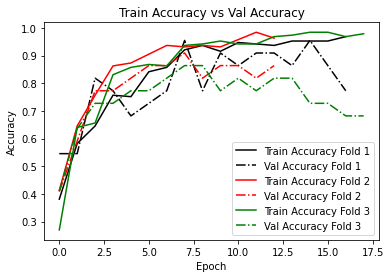

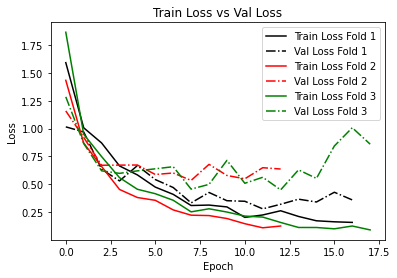

              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.62      1.00      0.77         5
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         8

    accuracy                           0.88        24
   macro avg       0.91      0.89      0.87        24
weighted avg       0.92      0.88      0.87        24



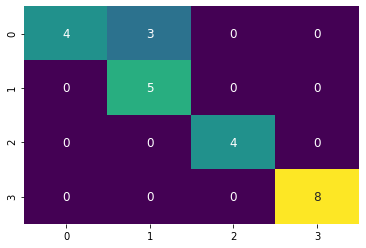

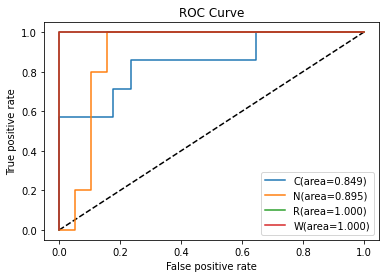

In [0]:
#Load the model that was saved by ModelCheckpoint

plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['acc'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_acc'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['acc'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_acc'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['acc'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_acc'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.title('Train Loss vs Val Loss')
plt.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

model = load_model('fas_mnist_1.h5')
modelresults(model,x_test,y_test)

In [0]:
# serialize model to JSON
model_json = m.to_json()
with open("BaghelStethoscope.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m.save_weights("BaghelStethoscope.h5")
print("Saved model to disk")

NameError: ignored

In [0]:
m.save('StethoscopeCNNLUNGS.model')

In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred_keras[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_keras[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_pred_keras.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred_keras,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))